In [3]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torchvision import transforms
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt
import time

import pandas as pd

In [2]:
path = "/home/borowis/s3"
bs = 256

In [5]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_data = ImageFolder(path + "/train_data/medium", trans)
train_loader = DataLoader(train_data, bs, shuffle=True, num_workers=8)

In [15]:
val_data = ImageFolder(path + "/validation_classification/medium", trans)
val_loader = DataLoader(val_data, bs, shuffle=True, num_workers=8)

In [122]:
print(train_data.class_to_idx)

{'0': 0, '1': 1, '10': 2, '100': 3, '1000': 4, '1001': 5, '1002': 6, '1003': 7, '1004': 8, '1005': 9, '1006': 10, '1007': 11, '1008': 12, '1009': 13, '101': 14, '1010': 15, '1011': 16, '1012': 17, '1013': 18, '1014': 19, '1015': 20, '1016': 21, '1017': 22, '1018': 23, '1019': 24, '102': 25, '1020': 26, '1021': 27, '1022': 28, '1023': 29, '1024': 30, '1025': 31, '1026': 32, '1027': 33, '1028': 34, '1029': 35, '103': 36, '1030': 37, '1031': 38, '1032': 39, '1033': 40, '1034': 41, '1035': 42, '1036': 43, '1037': 44, '1038': 45, '1039': 46, '104': 47, '1040': 48, '1041': 49, '1042': 50, '1043': 51, '1044': 52, '1045': 53, '1046': 54, '1047': 55, '1048': 56, '1049': 57, '105': 58, '1050': 59, '1051': 60, '1052': 61, '1053': 62, '1054': 63, '1055': 64, '1056': 65, '1057': 66, '1058': 67, '1059': 68, '106': 69, '1060': 70, '1061': 71, '1062': 72, '1063': 73, '1064': 74, '1065': 75, '1066': 76, '1067': 77, '1068': 78, '1069': 79, '107': 80, '1070': 81, '1071': 82, '1072': 83, '1073': 84, '1074

In [10]:
class SimpleNet(nn.Module):
        
    def __init__(self):
        super(SimpleNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU())

        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.drop_out = nn.Dropout(p=0.2)

        self.fc = nn.Linear(4 * 4 * 128, 2300)
        
    def forward(self, x):
        
        #Size changes from (3, 32, 32) to (32, 32, 32) to (32, 16, 16)
        x = self.layer1(x)
        
        #Size changes from (32, 16, 16) to (64, 16, 16) to (64, 8, 8)
        x = self.layer2(x)

        #Size changes from (64, 8, 8) to (128, 8, 8)
        x = self.layer3(x)

        #Size changes from (128, 8, 8) to (128, 8, 8) to (128, 4, 4)
        x = self.layer4(x)

        #Reshape data to input to the input layer of the neural net
        #Size changes from (128, 4, 4) to (1, 2048)
        x = x.view(-1, 128 * 4 * 4)
        x = self.drop_out(x)
        
        #Computes the activation of the first fully connected layer
        #Size changes from (1, 2048) to (1, 2300)
        x = self.fc(x)
        
        return x

In [11]:
model = SimpleNet()

criterion = nn.CrossEntropyLoss()
print(model)

optimizer = optim.Adam(model.parameters())

SimpleNet(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.2)
  (fc): Linear(in_features=2048, out_features=2301, bias=True)
)


In [12]:
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    model.cuda()

    running_loss = 0.0
    
    start_time = time.time()
    for batch_idx, (data, target) in enumerate(train_loader):   
        optimizer.zero_grad()   
        data = data.cuda()
        target = target.long().cuda()

        outputs = model(data)
        loss = criterion(outputs, target)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()
    
    end_time = time.time()
    
    running_loss /= len(train_loader)
    print('Training Loss: ', running_loss, 'Time: ',end_time - start_time, 's')
    return running_loss

In [13]:
def test_model(model, val_loader, criterion):
    with torch.no_grad():
        model.eval()
        model.cuda()

        running_loss = 0.0
        total_predictions = 0.0
        correct_predictions = 0.0

        for batch_idx, (data, target) in enumerate(val_loader):   
            data = data.cuda()
            target = target.long().cuda()

            outputs = model(data)

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += target.size(0)
            correct_predictions += (predicted == target).sum().item()

            loss = criterion(outputs, target).detach()
            running_loss += loss.item()

        running_loss /= len(val_loader)
        acc = (correct_predictions/total_predictions)*100.0
        print('Validation Loss: ', running_loss)
        print('Validation Accuracy: ', acc, '%')
        return running_loss, acc

In [14]:
n_epochs = 1
train_loss = []
val_loss = []
val_acc = []

In [22]:
for i in range(3):
    tl = train_epoch(model, train_loader, criterion, optimizer)
    vl, va = test_model(model, val_loader, criterion)
    
    train_loss.append(tl)
    val_loss.append(vl)
    val_acc.append(va)
    print('='*20)

Training Loss:  3.592047515500379 Time:  55.15519571304321 s
Validation Loss:  3.46629442109002
Validation Accuracy:  35.0141273636166 %
Training Loss:  3.465007746724382 Time:  53.951359033584595 s
Validation Loss:  3.356061644024319
Validation Accuracy:  36.90502064768529 %
Training Loss:  3.3685919449457047 Time:  54.912989139556885 s
Validation Loss:  3.305811047554016
Validation Accuracy:  37.79613127580961 %


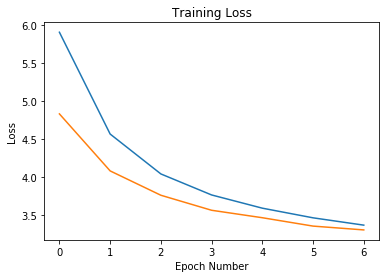

In [23]:
plt.title('Training Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(train_loss)
plt.plot(val_loss)

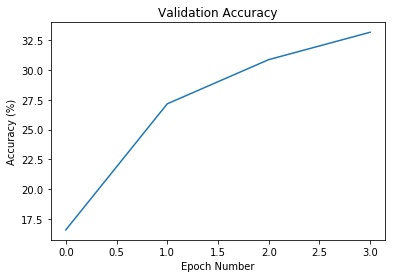

In [21]:
plt.title('Validation Accuracy')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy (%)')
plt.plot(val_acc)

In [45]:
test_data = ImageFolder(path + "/test_classification", trans)
test_loader = DataLoader(test_data, shuffle = False, batch_size = bs, num_workers = 8)

In [36]:
def inference(model, test_loader):
    with torch.no_grad():
        model.eval()
        model.cuda()

        preds = []
        for batch_idx, data in enumerate(test_loader):   
            data = data[0].cuda()
            outputs = model(data)

            _, predicted = torch.max(outputs.data, 1)
            preds.append(predicted.cpu().numpy())

        return np.concatenate(preds)

In [83]:
preds = inference(model, test_loader)

In [111]:
class_to_idx = train_data.class_to_idx
idx_to_class = {val: key for key, val in class_to_idx.items()}

In [131]:
ids = []
for idx, (pred, (file, _)) in enumerate(zip(preds, test_data.samples)):
    file_name = file[file.rfind('/') + 1 : file.rfind('.')]
    ids.append(int(file_name))

0 /home/borowis/s3/test_classification/medium/0.jpg
0 684 1613
1 /home/borowis/s3/test_classification/medium/1.jpg
1 1864 606
2 /home/borowis/s3/test_classification/medium/10.jpg
10 1015 1911
3 /home/borowis/s3/test_classification/medium/100.jpg
100 205 1182
4 /home/borowis/s3/test_classification/medium/1000.jpg
1000 1166 2047
5 /home/borowis/s3/test_classification/medium/1001.jpg
1001 868 178
6 /home/borowis/s3/test_classification/medium/1002.jpg
1002 255 1227
7 /home/borowis/s3/test_classification/medium/1003.jpg
1003 592 1530
8 /home/borowis/s3/test_classification/medium/1004.jpg
1004 1026 1921
9 /home/borowis/s3/test_classification/medium/1005.jpg
1005 1739 494


In [133]:
submit = pd.DataFrame({'label': preds}, index=ids)

submit.label = submit.label.map(idx_to_class)
submit.sort_index().head(20)

,label
0,1613
1,606
2,112
3,561
4,505
5,1040
6,1952
7,133
8,739
9,404


In [97]:
submit.to_csv(path + "/model0.csv", index=False)